# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

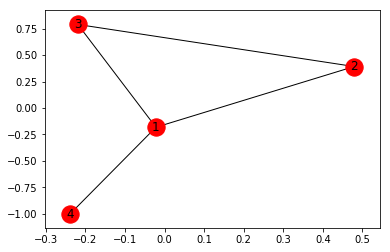

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here.

First let's load some data, like the Grimmer Senate press releases corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [16]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [18]:
len(g.nodes)

4270

Total number of edges:

In [19]:
len(g.edges)

2082420

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[14.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  0.,  1.],
        [ 0.,  1., 12.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  0., 26.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [23]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [24]:
senVects_incidence.shape

(100, 4270)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [25]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [26]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

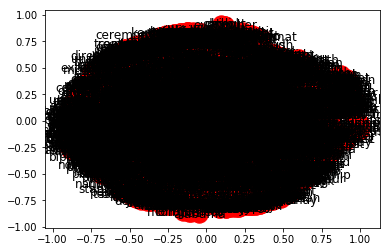

In [27]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [28]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [29]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [30]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

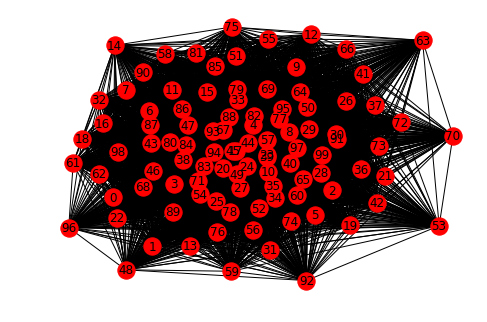

In [31]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

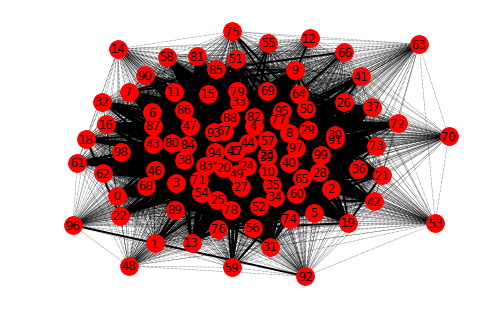

In [32]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [33]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [34]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [35]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [36]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [37]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1250])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


A bit smaller now, Now, let's visualize it: 

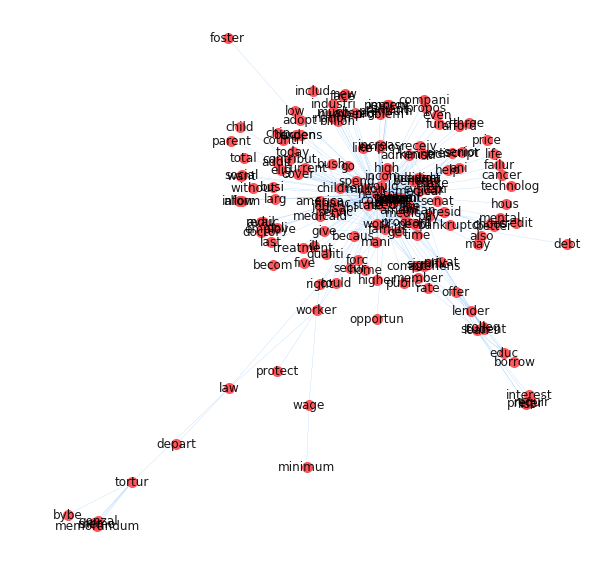

In [38]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [39]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


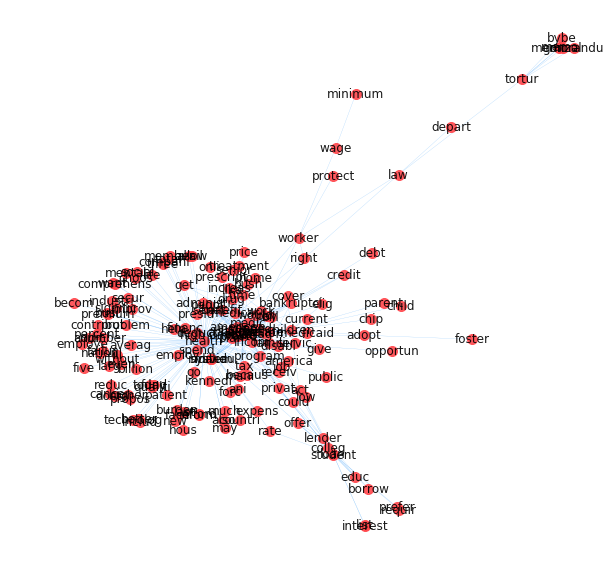

In [40]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [79]:
nx.clique.number_of_cliques(giant)['presid']

2

In [42]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, cost, plan, year, insur, save, provid, american, uninsur, account


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [43]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 22
Number of edges: 154
Average degree:  14.0000


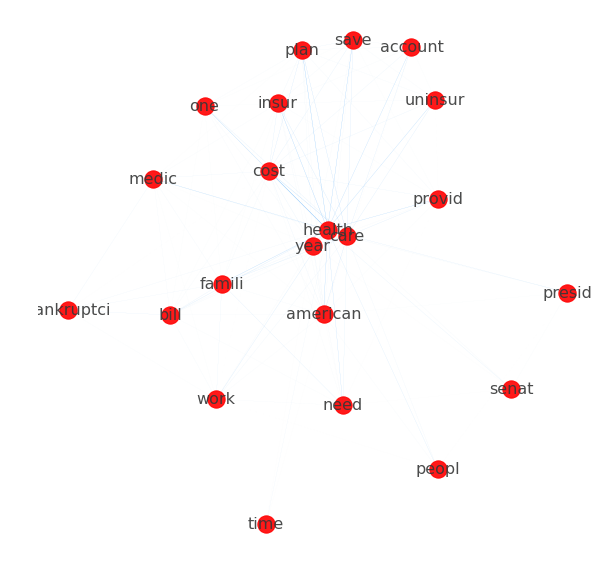

In [44]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [45]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [46]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 474
Average degree:   5.7455


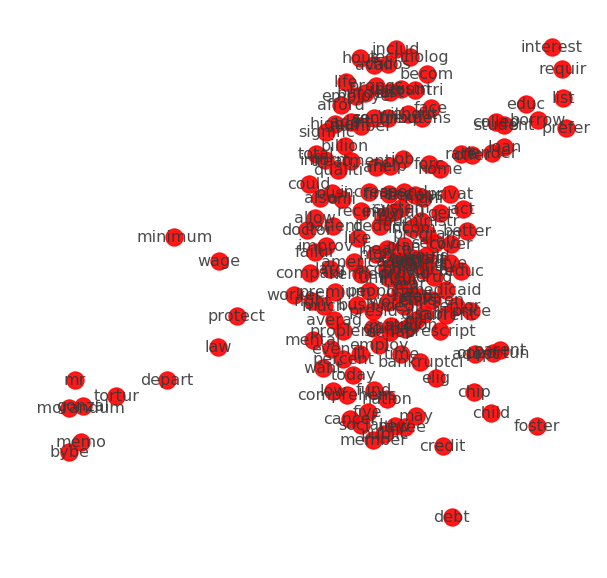

In [47]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [453]:
#For this week's assignment, I use the data that we will be using for our final project. We scraped a large corpus of
#soap opera transcripts from http://tvmegasite.net. This is a website maintained by elderly ladies that have been
#transcribing soap operas sind the late 1998 (check out the website if you like, it's quite funny!). Below, you can see
#a sample of the data from the tv show "All my Children. 
#We have speaking turns with character information, nested in scenes, nested in episodes with the date of the 
#airing of the episode.
soap_sentences = pandas.read_csv('/Users/Oscar/Dropbox/Week_8_data/sample_data.csv', 
                                index_col = 0, sep = "|")
soap_sentences[1:5]

,V1,filename,opera_name,show_year,show_date,scene,turn,text,speaker,speech
2,1,2001/04-09-01.txt,amc,2001,04-09-01,1,2,Gillian: So do you.,Gillian,So do you.
3,2,2001/04-09-01.txt,amc,2001,04-09-01,1,3,Ryan: That dress.,Ryan,That dress.
4,3,2001/04-09-01.txt,amc,2001,04-09-01,1,4,Gillian: It was my great-great-grandmother's. ...,Gillian,It was my great-great-grandmother's. Grandmama...
5,4,2001/04-09-01.txt,amc,2001,04-09-01,1,5,Ryan: How do you like my tux?,Ryan,How do you like my tux?


In [454]:
#Because the corpus is quite large, I will be using only a subset that contains all episodes of "All my Children" from
#the years 2001 and 2002. During that time, the show was aired 3 days a week. In my first exercise, I want to 
#create a network that captures the similarities the linguistic practive of the main characters. Therefore I created 
#a dataset where I aggregated all speech by a character during the two years in a long string.
#For my analyses here, I restrict myself to the 20 most characters that have the most speaking turns during that time.
soap_characters = pandas.read_csv('/Users/Oscar/Dropbox/Week_8_data/main_character_text.csv', 
                                index_col = 0, 
                                sep = "~~~")
soap_characters[1:4]

/Users/Oscar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,"""speaker""","""V1"""
"""6""","""Laura""","""You look beautiful! Yeah. I hate her. Just ki..."
"""7""","""Brooke""","""Congratulations. Doesn't Gillian look gorgeou..."
"""8""","""Edmund""","""Surprised? Oh, we're just sneaky, that's all...."


In [455]:
#Prepare data:
soap_characters['tokenized_sents'] = soap_characters['"V1"'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
soap_characters['normalized_sents'] = soap_characters['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [457]:
#I use the vectorizer you employed above.
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(soap_characters['"V1"'])
senVects_incidence[1:3]

<2x9331 sparse matrix of type '<class 'numpy.int64'>'
	with 3314 stored elements in Compressed Sparse Row format>

In [458]:
#I the fit the incidence matrix into a bipartite network graph (this will take a while).
g_2mode = nx.Graph()

#make nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [459]:
#Format of the bipartite network graph:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 9351
Number of edges: 46260
Average degree:   9.8941


In [462]:
#Then I use the contractNetwork function you defined above to create a network between the documents,
#that is, the linguistic practice of each of the 20 main characters.
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 190
Average degree:  19.0000


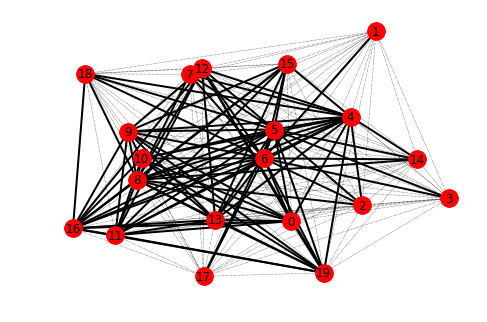

In [473]:
#Because my documents are fairly long, all characters are connected by an edge.
#Also not that natural speech - more so than written statements - tends to use the same words over and over again
#("make," "want," etc.). Therefore, I distinguish edges based on whether their weight is above or below the median.

#Below, you see a network of the linguistic practice of the 20 main characters of "All my children."
#We can see that some characters are far more central than others.
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [475]:
#When comparing the number of words that a character has contributed to the show, it becomes apparent that
#ties are driven by document length. The characters with many ties have contributed more speech than characters
#in the periphery.

print("Inner nodes:")
print(len(soap_characters.iloc[0]['"V1"']),"words")
print(len(soap_characters.iloc[4]['"V1"']),"words")
print(len(soap_characters.iloc[5]['"V1"']),"words")
print(len(soap_characters.iloc[6]['"V1"']),"words","\n")

print("Outer nodes:")
print(len(soap_characters.iloc[17]['"V1"']),"words")
print(len(soap_characters.iloc[1]['"V1"']),"words")
print(len(soap_characters.iloc[14]['"V1"']),"words")
print(len(soap_characters.iloc[3]['"V1"']),"words")

Inner nodes:
292120 words
306141 words
450064 words
420012 words 

Outer nodes:
174439 words
113192 words
166567 words
121237 words


In [479]:
#Next, I want to create some semantic networks. Therefore I use the co-occurrence function you defined above:
g = wordCooccurrence(soap_characters['normalized_sents'][:100].sum())
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 9336
Number of edges: 315711
Average degree:  67.6330


In [480]:
#My matrix is very sparse in comparison to yours. This has to do with the properties of natural speech.
#Sentences are much shorter. And while written press releases connect a high number of terms with topical
#connotation in them, natural speech in interaction might look something like:
#"Hmm.. like, I don't know, what do you think we should do?"
nx.to_numpy_matrix(g)[:5, :5]

matrix([[ 0.,  0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.]])

In [481]:
#Accounting for these different data structures I drop edges with a weights below threshold of 10.
#I also drop isolated terms to not mess up my plot:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 100])
g.remove_nodes_from(list(nx.isolates(g)))
giant = max(nx.connected_component_subgraphs(g), key=len)

Name: 
Type: Graph
Number of nodes: 107
Number of edges: 382
Average degree:   7.1402


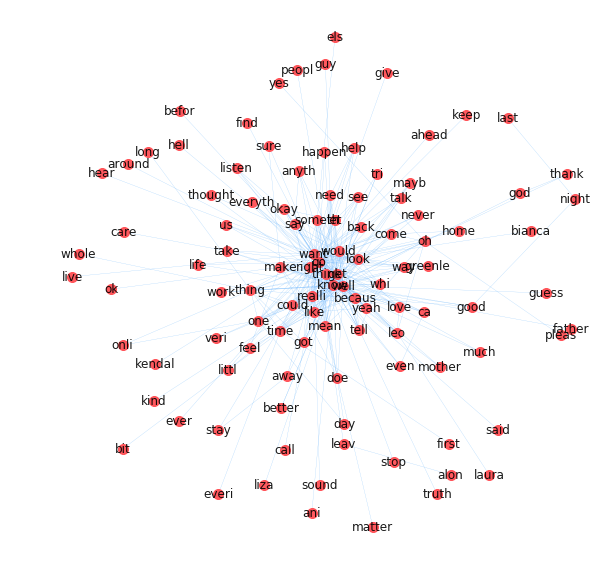

In [484]:
#I then plot the resulting network composed of 107 nodes, 382 edges and an average degree of 7.1.
#For my plot, I increase the float parameter k to push nodes further apart and make thinks look better.
#I find that there is a fairly densely connected core, mostly comprised of verbs like "know," "look," "would,"
#and "want." Frankly, when first looking at the graph, it does not strike one as particularly interesting.
#However, when thinking about it for a bit.. these are the core word of natural speech that we use in everyday language!
#This is how we talk. Most texts we have been working with ans seen throughout the quarter were from newspapers,
#press releases, or scientific abstracts. What the network does show quite strikingly is that the language we use
#in natural speech - and therefore most practices language - is quite different from these highly particularistic
#environments. Of course, these transcripts were scripted as well. But they were scripted to approximate natural speech
#and are thus very different from, say, scientific articles.
layout = nx.spring_layout(giant, weight='weight', iterations= 100, k=5)
fig, ax = plt.subplots(figsize = (10,10))
print(nx.info(giant))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

Name: 
Type: SubGraph
Number of nodes: 9
Number of edges: 32
Average degree:   7.1111


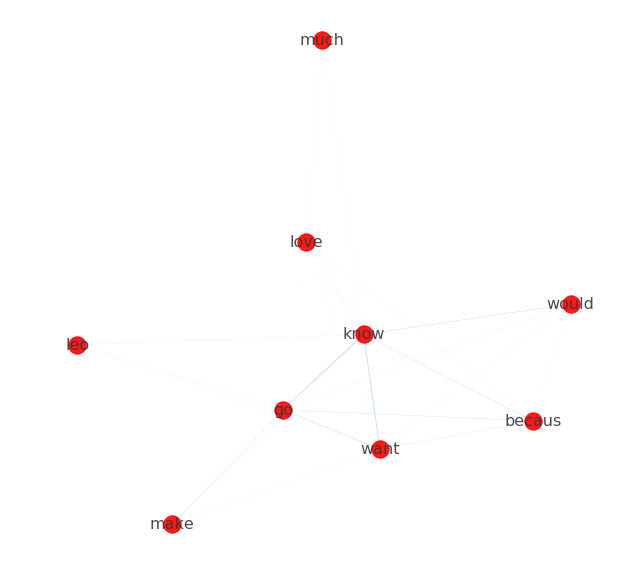

In [486]:
#Next, I am interested in love. I therefore create an ego network for this term together with its closest neighbors.
#The term is mostly associated with other verbs. Later in the notebook, I will be combining this with syntactic 
#information.
loveNeighbors = giant.neighbors('love')
g_love = g.subgraph(loveNeighbors)
print(nx.info(g_love))

layout_amer = nx.spring_layout(g_love, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_love.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_love.edges(data = True)))
nx.draw(g_love, ax = ax, pos = layout_amer, labels = {n:n for n in g_love.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_love.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Name: 
Type: SubGraph
Number of nodes: 10
Number of edges: 28
Average degree:   5.6000


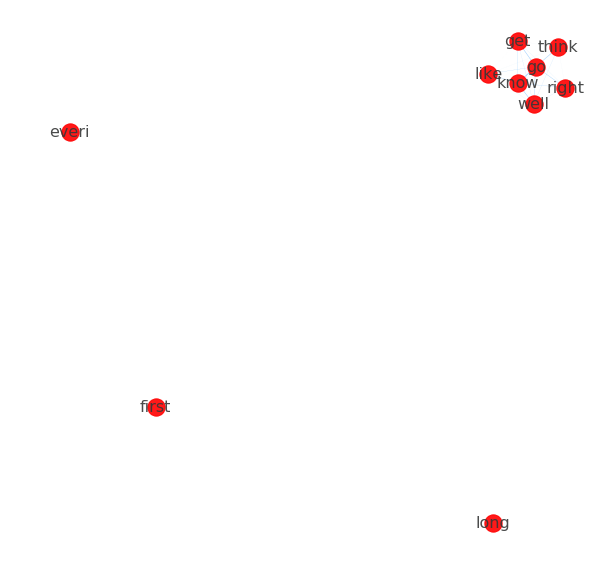

In [488]:
#Next I look at "time." Again we find strong connections to verby.
#Beyond that we find "first" "long" and "every."
timeNeighbors = giant.neighbors('time')
g_time = g.subgraph(timeNeighbors)
print(nx.info(g_time))

layout_amer = nx.spring_layout(g_time, weight='weight', iterations= 100, k = 5)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_time.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_time.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [103]:
#I ran this part in a seperate file
dcentralities = nx.degree_centrality(giant)

In [106]:
dcentralities['love']

0.09433962264150943

In [ ]:
max(dcentralities.items(), key = lambda x : x[1])

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

In [ ]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [ ]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [ ]:
centralities['senat']

In [ ]:
max(centralities.items(), key = lambda x : x[1])

We can color and size the nodes by betweenness centrality:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

What are words lower down?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [ ]:
centralities = nx.closeness_centrality(giant)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [ ]:
centralities = nx.eigenvector_centrality(giant)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [107]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [ ]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

In [ ]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [ ]:
nx.density(giant)

We can also calculate the average degree per node:

In [ ]:
np.mean([v for w,v in nx.degree(giant)])

The diameter calculates the average distance between any two nodes in the network:

In [ ]:
nx.diameter(giant)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [489]:
#First I look at degree centrality. What is quite striking is that the words with the highest degree centrality
#is that they are all verbs that can be used flexibly in many contexts. This is an interesting fact about natural 
#speech.
dcentralities = nx.degree_centrality(giant)

print("Highest centrality:")
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

Highest centrality:


[('go', 0.660377358490566),
 ('know', 0.6132075471698113),
 ('well', 0.3773584905660377),
 ('want', 0.3584905660377358),
 ('get', 0.3018867924528302),
 ('right', 0.25471698113207547),
 ('like', 0.22641509433962265),
 ('think', 0.21698113207547168),
 ('would', 0.18867924528301885),
 ('becaus', 0.16981132075471697)]

In [490]:
#The words with the lowest degree can not as easily be grouped into a syntactic category.
#However, when looking at them it is quite clear why they are not as central as the ones above.
#They are more particularistic and not used in as many contexts.
#However we need to keep in mind that this is still the core of the semantic network
#and therefore these nodes are probably still very central compared to all the words that we cut out above.
print("Lowest centrality:")
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Lowest centrality:


[('long', 0.009433962264150943),
 ('kendal', 0.009433962264150943),
 ('alon', 0.009433962264150943),
 ('ever', 0.009433962264150943),
 ('guy', 0.009433962264150943),
 ('first', 0.009433962264150943),
 ('liza', 0.009433962264150943),
 ('last', 0.009433962264150943),
 ('care', 0.009433962264150943),
 ('truth', 0.009433962264150943)]

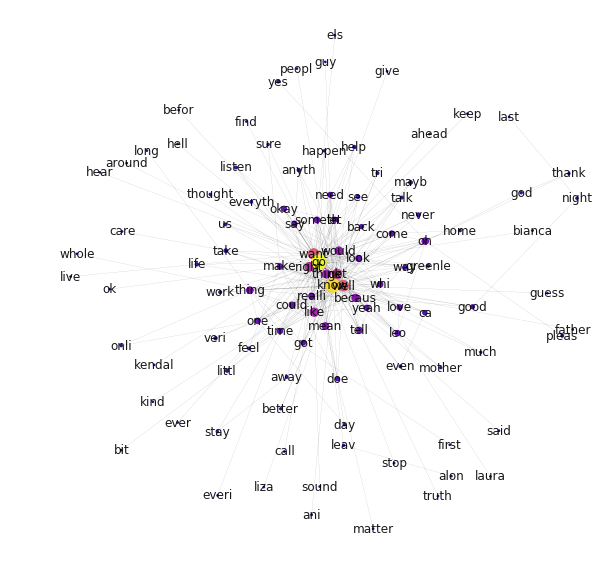

In [493]:
#The plot shows that degree centrality strongly differs between words.
#As indicted above, the center of the network is occupied by very flexibe verbs that can be used in many contexts.
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

In [494]:
#Betweenness centrality measures the number of times a node acts as a bridge along the shortest path between two 
#other nodes in the network. I find that almost the exact same words have the highest centrality as with the
#degree measure. Of course these are related but the similarity is quite striking.
bcentralities = nx.betweenness.betweenness_centrality(giant)

print("Highest betweenness centrality:")
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

Highest betweenness centrality:


[('go', 0.43686384993662625),
 ('know', 0.3324333298726828),
 ('well', 0.08634282658541417),
 ('oh', 0.07477887591095138),
 ('want', 0.059052544739876256),
 ('time', 0.056064690026954175),
 ('good', 0.03737646001796945),
 ('thing', 0.02940478758538057),
 ('get', 0.027511534587006295),
 ('like', 0.026780147824622232)]

In [495]:
#The same goes for the words with lowest betweenness centrality.
print("Lowest betweenness centrality:")
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Lowest betweenness centrality:


[('alon', 0.0),
 ('ever', 0.0),
 ('guy', 0.0),
 ('first', 0.0),
 ('liza', 0.0),
 ('last', 0.0),
 ('care', 0.0),
 ('pleas', 0.0),
 ('sure', 0.0),
 ('truth', 0.0)]

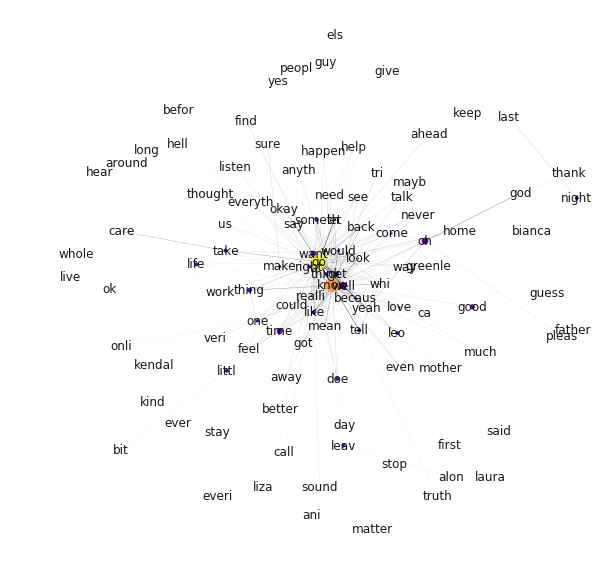

In [492]:
#Betweenness centrality appears to be more unevenly distributed than degree centrality.
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(bcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities[n] / maxC for n in giant.nodes],
        node_size = [bcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [496]:
#Again, I find pretty much the exact same words for closeness centrality in the top and the bottom ones.
close_centralities = nx.closeness_centrality(giant)

print("Highest closeness centrality:")
sorted(close_centralities.items(), key = lambda x: x[1], reverse = True)[:10]

Highest closeness centrality:


[('go', 0.7162162162162162),
 ('know', 0.7019867549668874),
 ('well', 0.5955056179775281),
 ('want', 0.5638297872340425),
 ('get', 0.5435897435897435),
 ('right', 0.5380710659898477),
 ('think', 0.53),
 ('like', 0.5196078431372549),
 ('becaus', 0.5023696682464455),
 ('would', 0.49765258215962443)]

In [497]:
print("Lowest closeness centrality:")
sorted(close_centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Lowest closeness centrality:


[('first', 0.3261538461538461),
 ('truth', 0.3261538461538461),
 ('laura', 0.32515337423312884),
 ('care', 0.3192771084337349),
 ('bit', 0.31736526946107785),
 ('live', 0.31736526946107785),
 ('matter', 0.301994301994302),
 ('night', 0.30113636363636365),
 ('alon', 0.29775280898876405),
 ('last', 0.23194748358862144)]

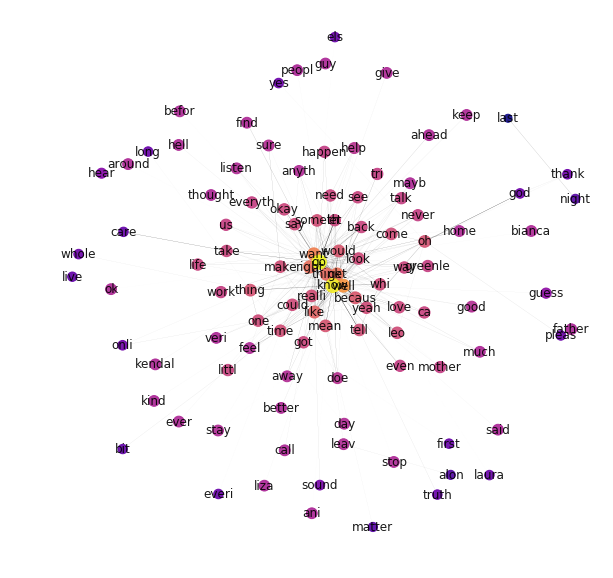

In [498]:
#However, closeness centrality is more evenly distributed accross nodes then the prior two measures.
#Th
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(close_centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [close_centralities[n] / maxC for n in giant.nodes],
        node_size = [close_centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [499]:
#Finally, I look at eigenvector centrality, again I find flexible verbs like "know" "want" "get" "go" among the mots
#central words and similar words to be the least central ones as above.
eig_centralities = nx.eigenvector_centrality(giant)

print("Highest eigenvector centrality:")
sorted(eig_centralities.items(), key = lambda x: x[1], reverse = True)[:10]

Highest eigenvector centrality:


[('know', 0.3396407768250011),
 ('go', 0.33861353244742654),
 ('well', 0.2796613008607949),
 ('want', 0.2622026730222202),
 ('get', 0.2435846121559071),
 ('right', 0.22641881209205716),
 ('like', 0.21033433176270155),
 ('think', 0.207282653385766),
 ('would', 0.18086601441337308),
 ('becaus', 0.1792880486834702)]

In [500]:
#Here are the least central words according to eigenvector centrality. I spare you the plot this time.
print("Lowest eigenvector centrality:")
sorted(eig_centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Lowest eigenvector centrality:


[('long', 0.005480497457752811),
 ('first', 0.005480497457752811),
 ('laura', 0.004945622891690316),
 ('care', 0.0036018611174837727),
 ('matter', 0.0034315968839635394),
 ('bit', 0.0028278219036822856),
 ('live', 0.0027762835879191904),
 ('night', 0.0025005333771643003),
 ('alon', 0.0009996060970972039),
 ('last', 0.00013566330375801923)]

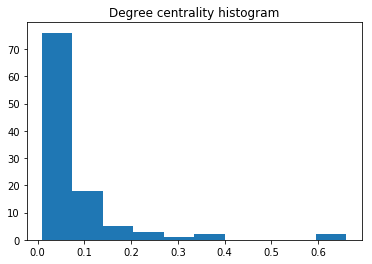

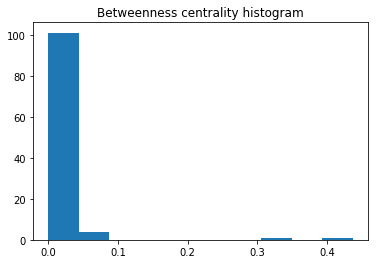

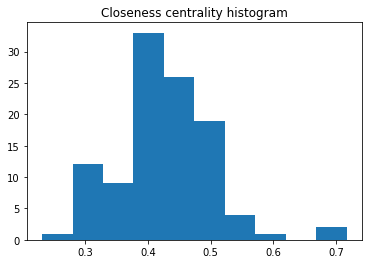

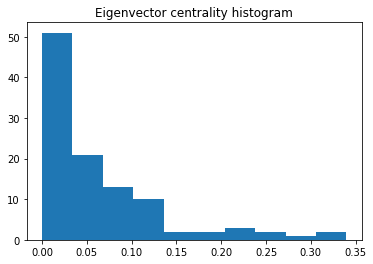

In [501]:
#Finally I look at the distributions of the different measures.
#I find that, indeed, as I speculated above, betweenness centrality is the most unevenly distributed measure, followed
#by degree centrality and eigenvector centrality. The closeness centrality measure seems to 
#be almost normally distributed.

#Degree centrality histogram:
plt.hist(list(dcentralities.values()))
plt.title('Degree centrality histogram')
plt.show()

#Betweenness centrality histogram:
plt.hist(list(bcentralities.values()))
plt.title('Betweenness centrality histogram')
plt.show()

#Closeness centrality histogram:
plt.hist(list(close_centralities.values()))
plt.title('Closeness centrality histogram')
plt.show()

#Eigenvector centrality histogram:
plt.hist(list(eig_centralities.values()))
plt.title('Eigenvector centrality histogram')
plt.show()

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [ ]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

Now we'll normalize the tokens through stemming:

In [ ]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [195]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [ ]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [ ]:
print(nx.info(gNN))

This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [ ]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

And low weight edges:

In [ ]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

In [ ]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [ ]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [ ]:
print(nx.info(gNV))

In [ ]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [ ]:
print(nx.info(gNV))

Dropping low weight edges and low degree vertices gives us:

In [ ]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [ ]:
print(nx.info(gNV))

In [ ]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [ ]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [ ]:
print(nx.info(g_i))

In [ ]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [ ]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

In [ ]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [ ]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [ ]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Or eigenvector centrality:

In [ ]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

In [ ]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

In [ ]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [ ]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

In [ ]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [506]:
soap_sentences = pandas.read_csv('/Users/Oscar/Dropbox/Week_8_data/main_character_text.csv', 
                                index_col = 0, 
                                sep = "~~~")
soap_sentences['sentences'] = soap_sentences['"V1"'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
soap_sentences.index = range(len(soap_sentences) - 1, -1,-1)
soap_sentences['normalized_sents'] = soap_sentences['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

/Users/Oscar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,"""speaker""","""V1""",sentences,normalized_sents
18,"""Laura""","""You look beautiful! Yeah. I hate her. Just ki...","[[``, You, look, beautiful, !], [Yeah, .], [I,...","[[you, look, beauti], [yeah], [i, hate, her], ..."
17,"""Brooke""","""Congratulations. Doesn't Gillian look gorgeou...","[[``, Congratulations, .], [Does, n't, Gillian...","[[congratul], [doe, gillian, look, gorgeous], ..."
16,"""Edmund""","""Surprised? Oh, we're just sneaky, that's all....","[[``, Surprised, ?], [Oh, ,, we, 're, just, sn...","[[surpris], [oh, we, just, sneaki, that, all],..."
15,"""David""","""Your honor, I am guilty of all charges, and I...","[[``, Your, honor, ,, I, am, guilty, of, all, ...","[[your, honor, i, am, guilti, of, all, charg, ..."
14,"""Leo""","""David, shut up! You're talking crazy. Your ho...","[[``, David, ,, shut, up, !], [You, 're, talki...","[[david, shut, up], [you, talk, crazi], [your,..."
13,"""Greenlee""","""Leo, Leo, Leo -- come on, come on. You're jus...","[[``, Leo, ,, Leo, ,, Leo, --, come, on, ,, co...","[[leo, leo, leo, come, on, come, on], [you, ju..."
12,"""Bianca""","""Mom -- what are you doing here? Mom, you don'...","[[``, Mom, --, what, are, you, doing, here, ?]...","[[mom, what, are, you, do, here], [mom, you, d..."
11,"""Erica""","""Oh -- David -- poor David -- he's just -- he ...","[[``, Oh, --, David, --, poor, David, --, he, ...","[[oh, david, poor, david, he, just, he, just, ..."
10,"""Jake""","""Tad, you need to get Dixie out of here. For G...","[[``, Tad, ,, you, need, to, get, Dixie, out, ...","[[tad, you, need, to, get, dixi, out, of, here..."


In [507]:
#First, I only look at nouns:
gNN = posCooccurrence(soap_sentences['normalized_sents'].sum(), 'NN')

In [508]:
#And restrict the network:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 500])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 299
Average degree:  24.9167


In [509]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 20])
gNN.remove_nodes_from(list(nx.isolates(gNN)))
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 93
Average degree:   7.7500


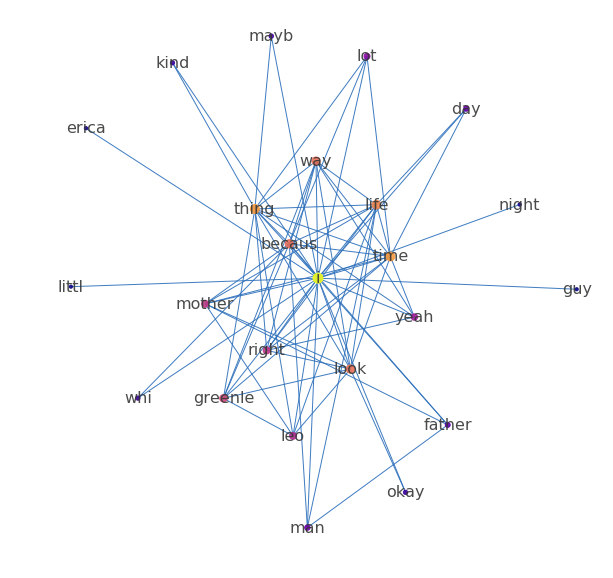

In [512]:
#Just as with your data, I find "I" to be in the very center of the graph. We see a clear core periphery structure of
#the network graph. We find quite a few character names in this plot.
#However, the graph also shows that the POS tagger is not doing an ideal job, unless I messed something up somewhere.
#It does seem plausible though, that the POS tagger would have a harder time with spoked data than with
#say the NYT. Often, sentences are interrupted or not finished in natural speech.
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100, k=10)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [514]:
#Next, I want to look at adjectives and nouns.
gJJ_NN = posCooccurrence(soap_sentences['normalized_sents'].sum(), 'JJ', 'NN')

In [515]:
#Same threshold seems to work ok. I did play around with this but at the end I simply picked something.
gJJ_NN.remove_nodes_from([n for n in gJJ_NN.nodes if len(set(gJJ_NN.neighbors(n))) <= 500])
print(nx.info(gJJ_NN))

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 2665
Average degree:  72.0270


In [521]:
gJJ_NN.remove_edges_from([(n1, n2) for n1, n2, d in gJJ_NN.edges(data = True) if d['weight'] <= 30])
gJJ_NN.remove_nodes_from(list(nx.isolates(gJJ_NN))) #since we are changing the graph list() evaluates the isolates first
print(nx.info(gJJ_NN))

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 186
Average degree:   5.0270


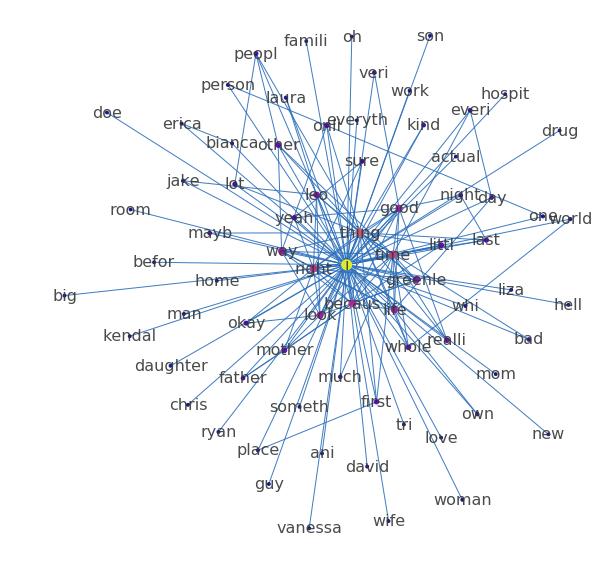

In [522]:
#Adjectives generally tend to be placed closer to the center with higher eigenvector centrality. 
#I find bigrams that make a lot of sense and are common in language like "bad guy," "good idea," "old men." 
#But generally the POS tagger seems to work very badly on my corpus. Also, there is a strong imbalance with
#most words being nouns and not adjectives.
layout_jj_nn = nx.spring_layout(gJJ_NN, weight='weight', iterations= 100, k = 5)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gJJ_NN)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gJJ_NN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gJJ_NN.edges(data = True)))
nx.draw(gJJ_NN, ax = ax, pos = layout_jj_nn, labels = {n: n for n in gJJ_NN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gJJ_NN.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gJJ_NN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [525]:
#Next, I extract verbs and nouns, because I want to see who "loves" or what is being "loved."
#Here I find some character names like "Grenlee" and "Leo" but I also "mother."
#However, most terms in the ego network appear to be other verbs.
gNV = posCooccurrence(soap_sentences['normalized_sents'].sum(), 'VB', 'NN')
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 500])
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 30])
print(nx.info(gNV))
g_love = gNV.subgraph(['love'] + list(gNV.neighbors('love')))
print(nx.info(g_love))

Name: 
Type: Graph
Number of nodes: 88
Number of edges: 554
Average degree:  12.5909
Name: 
Type: SubGraph
Number of nodes: 13
Number of edges: 81
Average degree:  12.4615


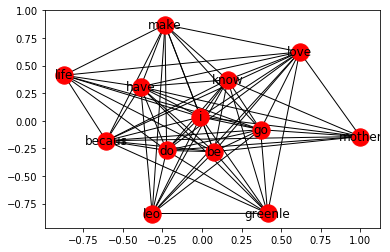

In [526]:
nx.draw_networkx(g_love)

Name: 
Type: SubGraph
Number of nodes: 88
Number of edges: 554
Average degree:  12.5909


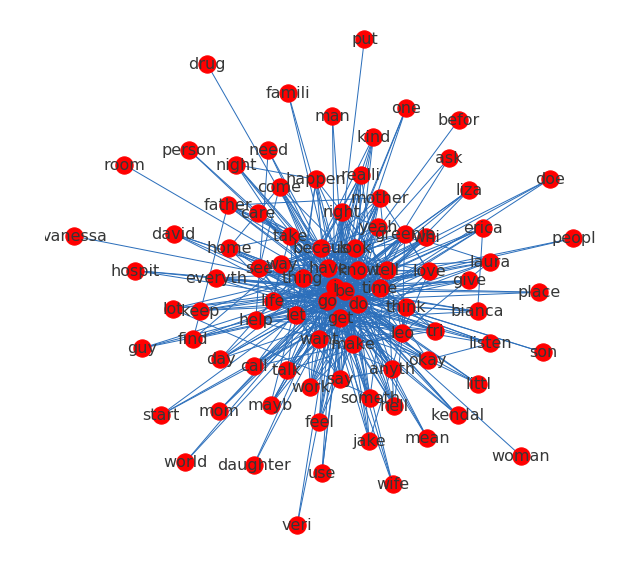

In [527]:
#Two steps from love.. many more character names. Interestingly, most of them appear to be women.
#Also some other family roles like father.. reasonable to love those.. sometimes.
loveNeighbors = set(gNV.neighbors('love'))
loveNeighborsPlus1 = set(loveNeighbors)
for n in loveNeighbors:
    loveNeighborsPlus1 |= set(gNV.neighbors(n))

gNV_love = gNV.subgraph(loveNeighborsPlus1)
print(nx.info(gNV_love))

love_layout = nx.spring_layout(gNV_love, weight='weight', iterations= 100, k=5)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_love, ax = ax, pos = love_layout, labels = {n: n for n in gNV_love.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [554]:
#Now three steps from love..

#Lower threshold because difference between 2 and three steps was really minor with current settings.
gNV = posCooccurrence(soap_sentences['normalized_sents'].sum(), 'VB', 'NN')
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 300])
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 20])

In [555]:
print(nx.info(gNV))

loveNeighbors = set(gNV.neighbors('love'))
loveNeighborsPlus1 = set(loveNeighbors)
for n in loveNeighbors:
    loveNeighborsPlus1 |= set(gNV.neighbors(n))

loveNeighborsPlus2 = set(loveNeighborsPlus1)
for n in loveNeighborsPlus1:
    loveNeighborsPlus2 |= set(gNV.neighbors(n))

Name: 
Type: Graph
Number of nodes: 194
Number of edges: 1180
Average degree:  12.1649


In [556]:
#I find that the number doesn't really increase much anymore from there.
#Probably there are extremely dense words two steps away from love that
#are tied to nearly every words like "i." Once we have these, we reach almost
#every node in the network eachcep isolated with step 3.
print("Network members with one step:")
print(len(loveNeighbors))
print("Network members with two steps:")
print(len(loveNeighborsPlus1))
print("Network members with three steps:")
print(len(loveNeighborsPlus2))

Network members with one step:
23
Network members with two steps:
194
Network members with three steps:
194


In [557]:
loveNeighborsPlus2 = set(loveNeighbors)
gNV_love = gNV.subgraph(loveNeighborsPlus2)
print(nx.info(gNV_love))

Name: 
Type: SubGraph
Number of nodes: 23
Number of edges: 228
Average degree:  19.8261


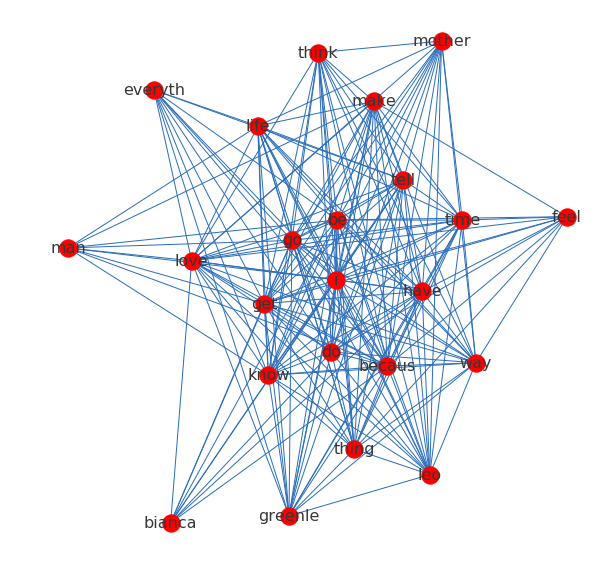

In [558]:
#I changed the network edge and node restroctions. So therefore we cannot really compare this plot directly 
#to the ones before.
love_layout = nx.spring_layout(gNV_love, weight='weight', iterations= 100, k=5)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_love, ax = ax, pos = love_layout, labels = {n: n for n in gNV_love.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id

In [426]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [425]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [423]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [424]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

Realtime output can be viewed in shell.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

In [441]:
#This seems like a perfect thing to try on my group discussion dataset that I used for some of my earlier assignments.
#However, I do not have time stemps, so I would have to find a clever way to approximate time with statement length
#or something like that. Before doing that, I will try out the functions with simulated data.

#Therefore, I first simulate a discussion between me, you, some other guy, Jeb Bush, Shakira, Gary King, 
#Frankie Knuckles, and a lama. This conversation is held in fake English.
script= []
for i in range(200):
    dt = []
    dt.append(np.random.choice(['Me','You','Some other guy','Jeb Bush','Shakira','Gary King','Steve', 'A lama']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens)
    dt.append(i*2+np.random.random())
    dt.append(i*2+1+np.random.random())
    script.append(dt)

df_transcript = pandas.DataFrame(script, columns=['name','tokens','start','end'])
df_transcript[:10]

,name,tokens,start,end
0,Shakira,"[dses, hsak, llif, dggh, jbil, ibfj, lhlh, ccd...",0.166028,1.781738
1,Me,"[lgac, ablk, ceke, hhag, kjke, jlik, ifia, jbs...",2.741875,3.198380
2,A river rat,"[cfch, cdbg, ksjh, jbdl, ffgh, kebc, dkak, ggc...",4.446915,5.630557
3,Some other guy,"[fbdg, beef, ikik, gccc, bdgl, gsgj, ljlk, dis...",6.749388,7.852962
4,Me,"[fbed, fahk, aihc, jbea, heca, sdec, ilhk, sad...",8.718191,9.449645
5,You,"[khid, cjgh, kebf, cadi, fkld, ichj, lsak, bei...",10.435984,11.250614
6,Steve,"[heek, ckbh, hhia, cgca, hsgf, jgsg, lhdh, lac...",12.638593,13.409455
7,Steve,"[egjd, idlj, eell, kjdi, kaji, ibdd, ebcj, fsb...",14.580476,15.174097
8,Jeb Bush,"[jssg, bjsc, hgjh, ecgg, lded, bece, laib, sjs...",16.489516,17.929718
9,You,"[jfhd, ilhf, dhlk, sfcs, fjik, bihh, gakf, seh...",18.076696,19.001435


In [443]:
output_fname = 'odd_conversation.xml'
language = 'eng' 
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language)

New File saved to ./data/odd_conversation/odd_conversation.xml


0

In [448]:
Vocab_size = 100
sampling_time = 1500
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

In [449]:
#So I really tried back and forth with the function and also looked into it's code in the bayesian echo folder.
#But I simply does not run.
#I'm not sure whether I'm missing out on something very simple here. But my datacorpus has the correct formas 
#(of course it does, because I use your function). The function simply does not create the respective folders.
#At this point I really don't know what to do. Did other have this problem too? I was surely hyped to find out
#the influence the lama had on Gary Kind.

create folder
data open bayesian folder look at code